In [1]:
import torch 
import os 
import cv2 
from importlib import import_module 
import matplotlib.pyplot as plt 
import json 
import numpy as np 

/home/kjs2109/.conda/envs/deepai-kjs/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import sys 
sys.path.append('../') 
from inference.inference_model import load_model, load_ensemble_model 

In [3]:
model1 = load_model('unet', "EfficientUNet", ['Pnuemothorax'], use_aux=True, weight_path='/ai-data/chest/kjs2109/baseline/semseg-baseline/weight_dir/exp6_1f_effiU-b5_aux/dice-7716-60999.pth') 
model2 = load_model('unet', "EfficientUNet", ['Pnuemothorax'], use_aux=True, weight_path='/ai-data/chest/kjs2109/baseline/semseg-baseline/weight_dir/exp16_1f_effiU-b5_aux-copypaste-noise1-v1/dice-7948-167999.pth') 

model_info = [
    {
        'model': 'unet', 
        'model_class': 'EfficientUNet', 
        'use_aux': True, 
        'exp_name': 'exp6_1f_effiU-b5_aux',
        'weight_fname': 'dice-7716-60999.pth'
    },
    {
        'model': 'unet', 
        'model_class': 'EfficientUNet', 
        'use_aux': True, 
        'exp_name': 'exp16_1f_effiU-b5_aux-copypaste-noise1-v1', 
        'weight_fname': 'dice-7948-167999.pth'
    },
]
ensemble_model = load_ensemble_model(model_info, ['Pnuemothorax'], '/ai-data/chest/kjs2109/baseline/semseg-baseline/weight_dir', 'weighted_soft') 

Successfully loaded model:  exp6_1f_effiU-b5_aux
Successfully loaded model:  exp16_1f_effiU-b5_aux-copypaste-noise1-v1


In [4]:
model1.eval(), model2.eval() 
model1.cuda(), model2.cuda() 
print('Done.')

Done.


In [5]:
import albumentations as A 

transform = A.Resize(512, 512) 

test_image = cv2.imread('/ai-data/chest/kjs2109/private_data/chestALL/images/BORA_CXR_010675.jpg', cv2.IMREAD_COLOR)
# test_image = cv2.imread('/ai-data/chest/kjs2109/pseudo_label_dataset/chestALL/images/VBD/VBD_CXR_000032.jpg')
transformed_test_image = transform(image=test_image)['image']
transformed_test_image = torch.from_numpy(transformed_test_image.transpose(2, 0, 1) / 255.).float().cuda()   

print(transformed_test_image.shape, transformed_test_image.max(), transformed_test_image.min(), transformed_test_image.dtype) 

torch.Size([3, 512, 512]) tensor(1., device='cuda:0') tensor(0., device='cuda:0') torch.float32


In [6]:
with torch.no_grad():
    output1 = model1(transformed_test_image.unsqueeze(0)) 
    output2 = model2(transformed_test_image.unsqueeze(0))  
    ensemble_output = ensemble_model(transformed_test_image.unsqueeze(0)) 

In [9]:
logit1 = output1['mask_output'] 
logit2 = output2['mask_output'] 

prob1 = torch.sigmoid(logit1) 
prob2 = torch.sigmoid(logit2) 
ensemble_prob = ensemble_output['mask_output']  

mask1 = (prob1 > 0.5) 
mask2 = (prob2 > 0.5) 
ensemble_mask = (ensemble_prob > 0.5)

cls1 = output1['cls_output'] 
cls2 = output2['cls_output'] 

cls_prob1 = torch.sigmoid(cls1) 
cls_prob2 = torch.sigmoid(cls2) 
ensemble_cls_prob = ensemble_output['cls_output'] 

print(logit1.shape, logit2.shape) 
print(logit1.max(), logit1.min(), logit1.dtype) 
print(logit2.max(), logit2.min(), logit2.dtype)
print('cls', cls1, cls2) 
print('cls prob', cls_prob1, cls_prob2, ensemble_cls_prob)  

torch.Size([1, 1, 512, 512]) torch.Size([1, 1, 512, 512])
tensor(5.6033, device='cuda:0') tensor(-25.8754, device='cuda:0') torch.float32
tensor(4.3996, device='cuda:0') tensor(-20.8049, device='cuda:0') torch.float32
cls tensor([[9.5004]], device='cuda:0') tensor([[5.5598]], device='cuda:0')
cls prob tensor([[0.9999]], device='cuda:0') tensor([[0.9962]], device='cuda:0') tensor([[0.9980]], device='cuda:0')


In [11]:
c1 = abs(cls_prob1 - 0.5) 
c2 = abs(cls_prob2 - 0.5)  
c1, c2 

(tensor([[0.4999]], device='cuda:0'), tensor([[0.4962]], device='cuda:0'))

In [12]:
c_mean = (c1 + c2) / 2 
print(c_mean) 

m1 = c1 - c_mean + 1 
m2 = c2 - c_mean + 1 

print(m1, m2) 

tensor([[0.4980]], device='cuda:0')
tensor([[1.0019]], device='cuda:0') tensor([[0.9981]], device='cuda:0')


In [22]:
2*torch.sqrt(m1 - 1) + 1 

tensor([[1.0867]], device='cuda:0')

In [20]:
-2*torch.sqrt(1 - m2) + 1

tensor([[0.9133]], device='cuda:0')

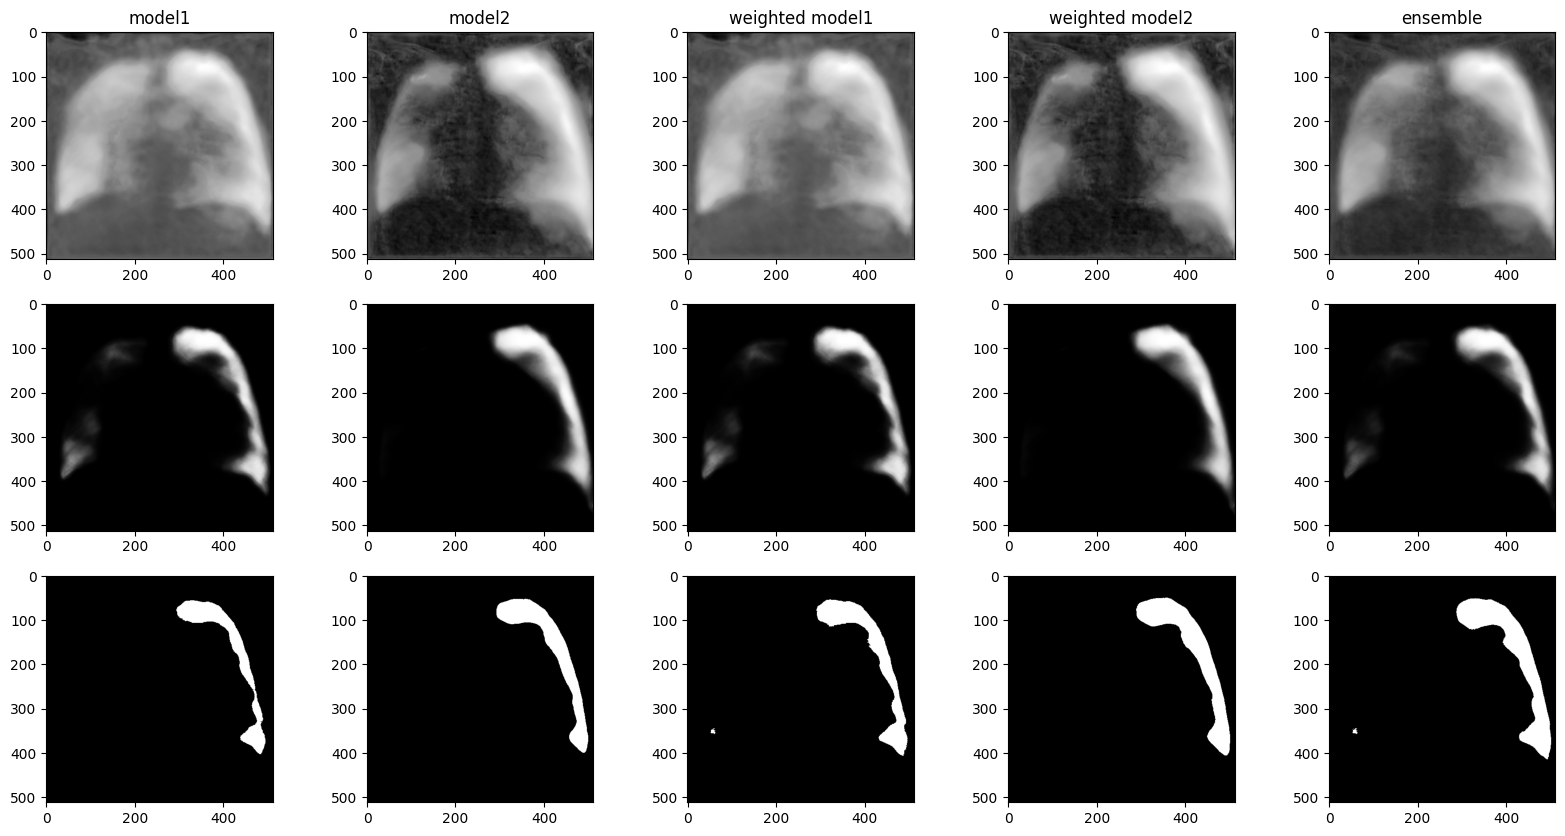

In [32]:
plt.figure(figsize=(20, 10)) 

plt.subplot(3, 5, 1)
plt.imshow(logit1.cpu().squeeze(), cmap='gray')  
plt.title('model1')

plt.subplot(3, 5, 2) 
plt.imshow(logit2.cpu().squeeze(), cmap='gray') 
plt.title('model2')

plt.subplot(3, 5, 3)
# plt.imshow(logit1.cpu().squeeze() * 1.0434, cmap='gray') 
plt.imshow(logit1.cpu().squeeze() * 1.0867, cmap='gray')
plt.title('weighted model1')

plt.subplot(3, 5, 4) 
# plt.imshow(logit2.cpu().squeeze() * 0.9566, cmap='gray')
plt.imshow(logit2.cpu().squeeze() * 0.9133, cmap='gray')
plt.title('weighted model2') 

plt.subplot(3, 5, 5)
plt.imshow((logit1.cpu().squeeze() * 1.0434 + logit2.cpu().squeeze() * 0.9566) / 2, cmap='gray')
plt.title('ensemble')

plt.subplot(3, 5, 6) 
plt.imshow(torch.sigmoid(logit1.cpu().squeeze()), cmap='gray') 

plt.subplot(3, 5, 7) 
plt.imshow(torch.sigmoid(logit2.cpu().squeeze()), cmap='gray') 

plt.subplot(3, 5, 8) 
plt.imshow(torch.sigmoid(logit1.cpu().squeeze() * 1.0434), cmap='gray') 

plt.subplot(3, 5, 9) 
plt.imshow(torch.sigmoid(logit2.cpu().squeeze() * 0.9566), cmap='gray') 

plt.subplot(3, 5, 10) 
plt.imshow((torch.sigmoid((logit1.cpu().squeeze() * 1.0434)) + torch.sigmoid(logit2.cpu().squeeze() * 0.9566) / 2), cmap='gray') 

plt.subplot(3, 5, 11)
plt.imshow((torch.sigmoid(logit1.cpu().squeeze() > 0.5)), cmap='gray') 

plt.subplot(3, 5, 12)
plt.imshow((torch.sigmoid(logit2.cpu().squeeze() > 0.5)), cmap='gray')

plt.subplot(3, 5, 13)
plt.imshow((torch.sigmoid(logit1.cpu().squeeze() * 1.0434) > 0.5), cmap='gray')

plt.subplot(3, 5, 14)
plt.imshow((torch.sigmoid(logit2.cpu().squeeze() * 0.9566) > 0.5), cmap='gray')

plt.subplot(3, 5, 15)
plt.imshow((torch.sigmoid(logit1.cpu().squeeze() * 1.0434) + torch.sigmoid(logit2.cpu().squeeze() * 0.9566) / 2) > 0.5, cmap='gray')

plt.show() 

In [ ]:
plt.subplot(3, 4, 1) 

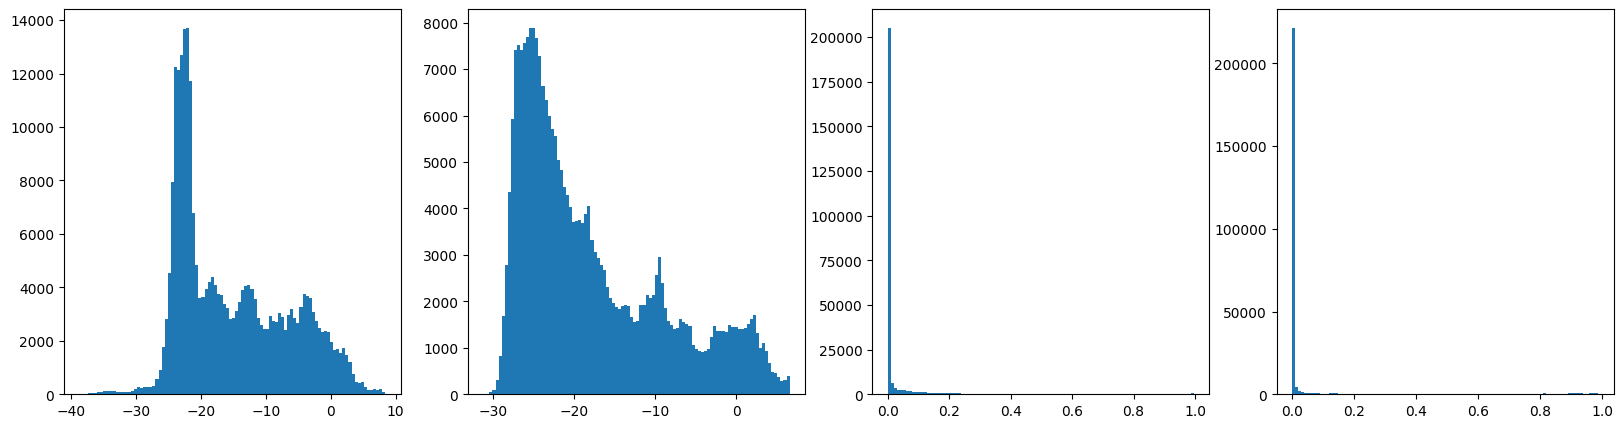

In [43]:
plt.figure(figsize=(20, 5)) 

plt.subplot(2, 3, 1)
plt.hist(logit1.flatten().numpy(), bins=100) 
# plt.xlim(-5, 5)

plt.subplot(2, 3, 2)
plt.hist(logit2.flatten().numpy(), bins=100)
# plt.xlim(-5, 5) 

plt.subplot(2, 3, 3) 
plt.hist((logit1.flatten().numpy() + logit2.flatten().numpy()) / 2, bins=100) 

plt.subplot(2, 4, 4) 
plt.hist(prob2.flatten().numpy(), bins=100)

plt.show() 

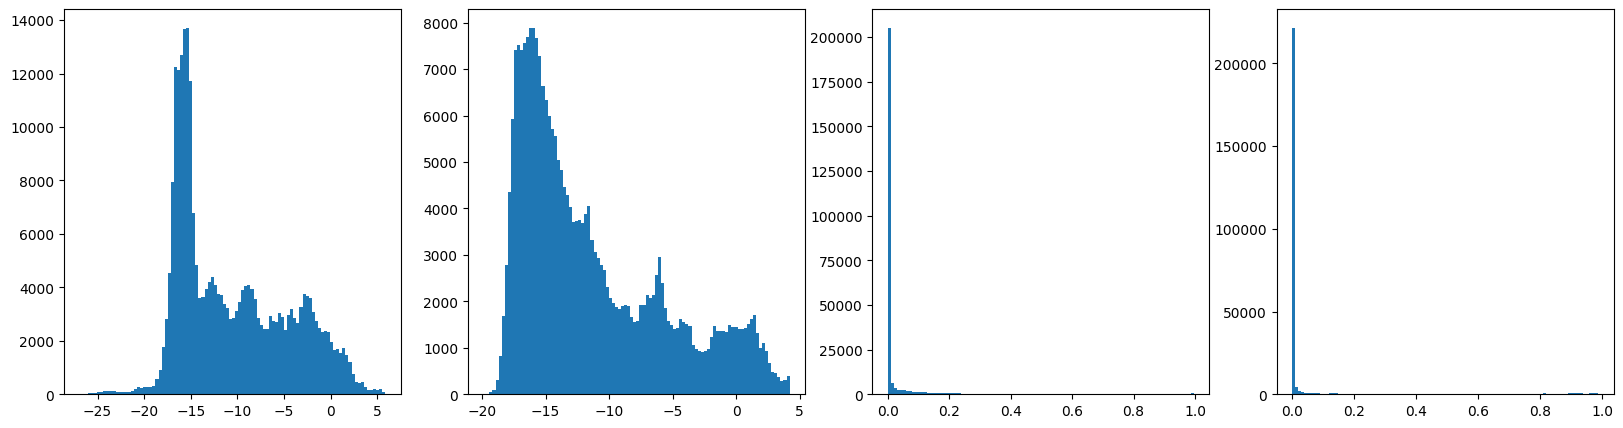

In [59]:
plt.figure(figsize=(20, 5)) 

plt.subplot(1, 4, 1)
plt.hist(logit1.flatten().numpy() * 1.0434, bins=100) 
# plt.xlim(-5, 5)

plt.subplot(1, 4, 2)
plt.hist(logit2.flatten().numpy() * 0.9566, bins=100)
# plt.xlim(-5, 5) 

plt.subplot(1, 4, 3) 
plt.hist(prob1.flatten().numpy(), bins=100) 

plt.subplot(1, 4, 4) 
plt.hist(prob2.flatten().numpy(), bins=100)

plt.show() 

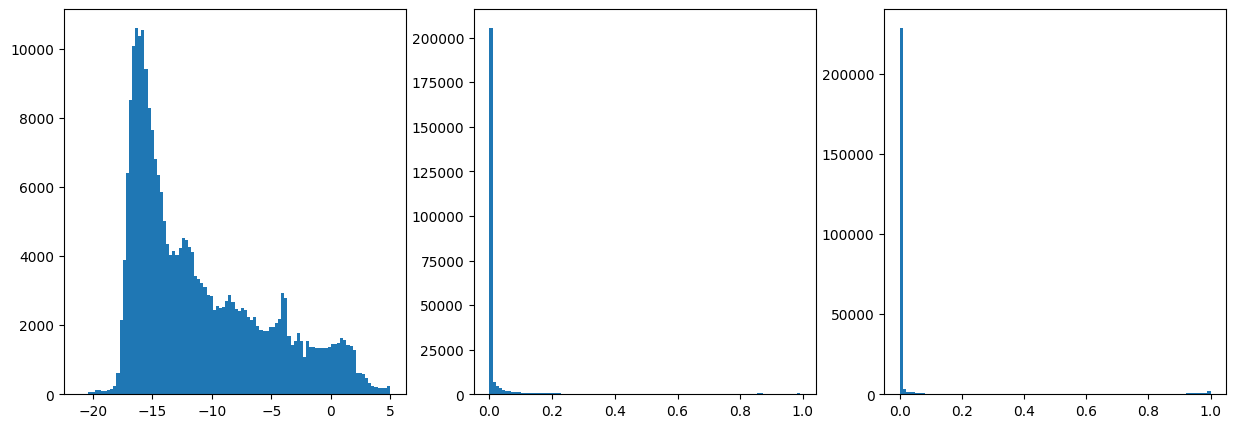

In [35]:
plt.figure(figsize=(15, 5)) 

plt.subplot(1, 3, 1)
plt.hist((logit1.flatten().cpu().numpy() * 1.0434 + logit2.flatten().cpu().numpy() * 0.9566) / 2, bins=100) 
# plt.xlim(-5, 5)

plt.subplot(1, 3, 2)
plt.hist((prob1.flatten().cpu().numpy() + prob2.flatten().cpu().numpy()) / 2, bins=100)  # probability에서 평균 
# plt.xlim(-5, 5) 

plt.subplot(1, 3, 3) 
plt.hist(torch.sigmoid((logit1.cpu().squeeze() + logit2.cpu().squeeze()/ 2)).flatten().numpy(), bins=100) # sigmoid에서 평균

plt.show() 

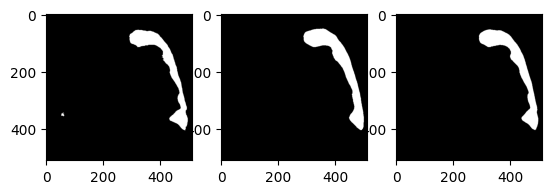

In [81]:
plt.subplot(1, 3, 1)
plt.imshow(mask1.cpu().squeeze(), cmap='gray')  

plt.subplot(1, 3, 2) 
plt.imshow(mask2.cpu().squeeze(), cmap='gray') 

plt.subplot(1, 3, 3)
plt.imshow(ensemble_mask.cpu().squeeze(), cmap='gray') 

plt.show() 

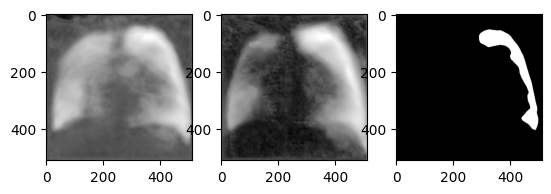

In [ ]:
with torch.no_grad():
    ensemble_output = ensemble_model(transformed_test_image.unsqueeze(0)) 

In [ ]:
logit1 = ensemble_output['mask_output'] 

prob1 = torch.sigmoid(logit1) 
prob2 = torch.sigmoid(logit2) 

mask1 = (prob1 > 0.5) 
mask2 = (prob2 > 0.5)

cls1 = output1['cls_output'] 
cls2 = output2['cls_output'] 

cls_prob1 = torch.sigmoid(cls1) 
cls_prob2 = torch.sigmoid(cls2) 

print(logit1.shape, logit2.shape) 
print(logit1.max(), logit1.min(), logit1.dtype) 
print(logit2.max(), logit2.min(), logit2.dtype) 
print(cls1, cls2) 
print(cls_prob1, cls_prob2)
print('-'*100) 
print()